In [1]:
#necessary for google colab
!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap, cm

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

In [3]:
#necessary steps for colab
mount_point = '/content/gdrive/'
drive.mount(mount_point)
# To access a shared folder, create a shorcut in My Drive
shortcut_path = "My Drive/CMPE 255 Project/"

#3.5 million record accident dataset from Kaggle
filename = 'accidents.csv' 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
data_path = os.path.join(mount_point, shortcut_path, filename)
#data_path = 
#substitute local path if you are working locally

In [5]:
df = pd.read_csv(data_path)

In [ ]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
df.describe()

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.478818e+06,3.513617e+06,3.513617e+06,3.513617e+06,1.034799e+06,1.034799e+06,3.513617e+06,1.250753e+06,3.447885e+06,1.645368e+06,3.443930e+06,3.457735e+06,3.437761e+06,3.059008e+06,1.487743e+06
mean,2.080226e+02,2.339929e+00,3.654195e+01,-9.579151e+01,3.755758e+01,-1.004560e+02,2.816167e-01,5.975383e+03,6.193512e+01,5.355730e+01,6.511427e+01,2.974463e+01,9.122644e+00,8.219025e+00,1.598256e-02
std,2.076627e+01,5.521935e-01,4.883520e+00,1.736877e+01,4.861215e+00,1.852879e+01,1.550134e+00,1.496624e+04,1.862106e+01,2.377334e+01,2.275558e+01,8.319758e-01,2.885879e+00,5.262847e+00,1.928262e-01
min,2.000000e+02,1.000000e+00,2.455527e+01,-1.246238e+02,2.457011e+01,-1.244978e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.010000e+02,2.000000e+00,3.363784e+01,-1.174418e+02,3.399477e+01,-1.183440e+02,0.000000e+00,8.640000e+02,5.000000e+01,3.570000e+01,4.800000e+01,2.973000e+01,1.000000e+01,5.000000e+00,0.000000e+00
50%,2.010000e+02,2.000000e+00,3.591687e+01,-9.102601e+01,3.779736e+01,-9.703438e+01,0.000000e+00,2.798000e+03,6.400000e+01,5.700000e+01,6.700000e+01,2.995000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.010000e+02,3.000000e+00,4.032217e+01,-8.093299e+01,4.105139e+01,-8.210168e+01,1.000000e-02,7.098000e+03,7.590000e+01,7.200000e+01,8.400000e+01,3.009000e+01,1.000000e+01,1.150000e+01,0.000000e+00
max,4.060000e+02,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,3.336300e+02,9.999997e+06,1.706000e+02,1.150000e+02,1.000000e+02,5.774000e+01,1.400000e+02,9.840000e+02,2.500000e+01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

## Exploratory Data Analysis




California and Texas show highest number of incidents. This can likely be explained by their large population. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


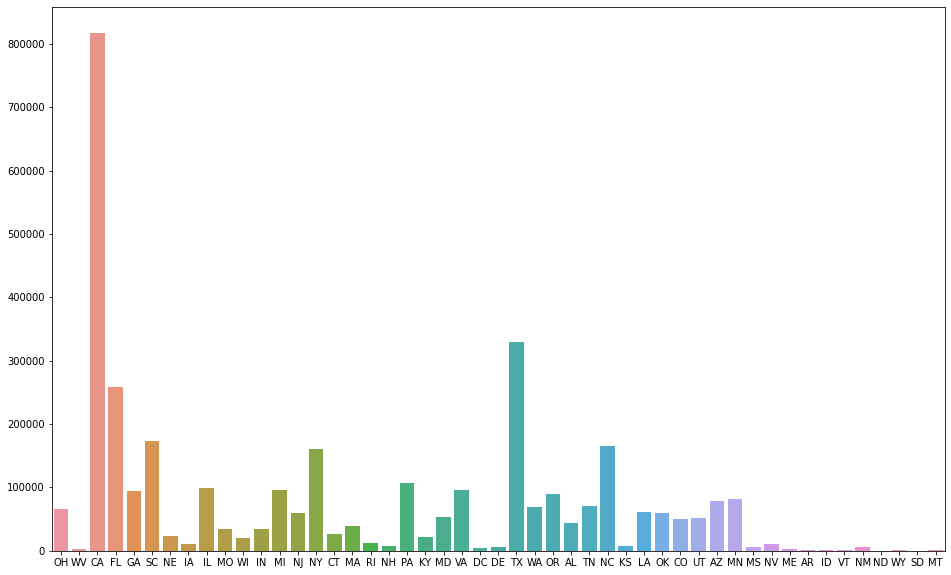

In [6]:
states = df.State.unique() #get list of states

#sum up incidents per state
state_incidents=[] 
for i in states:
    state_incidents.append(df[df['State']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(states,state_incidents)

lets check for the top5  Weather Condition for accidents

Text(0.5, 1.0, '5 Top Weather Conditions')

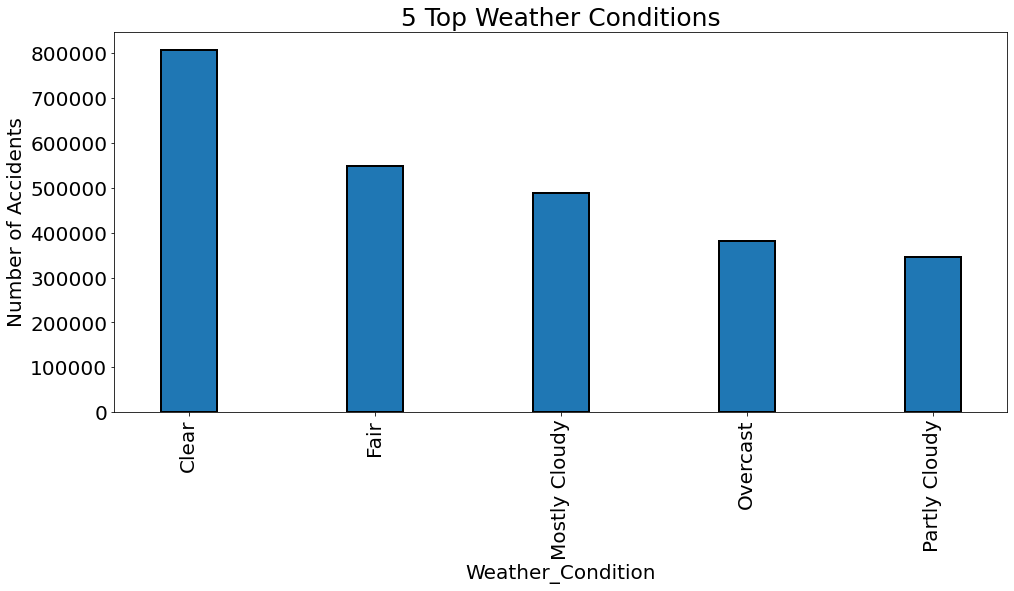

In [7]:
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.3,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Conditions',fontsize=25)

In [8]:
#convert timestamp into hourly information and trasform into two dimensions via sin/cosine transformations

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['hourfloat']=df['Start_Time'].dt.hour+df['Start_Time'].dt.minute/60.0
df['x']=np.sin(2.*np.pi*df.hourfloat/24.)
df['y']=np.cos(2.*np.pi*df.hourfloat/24.)

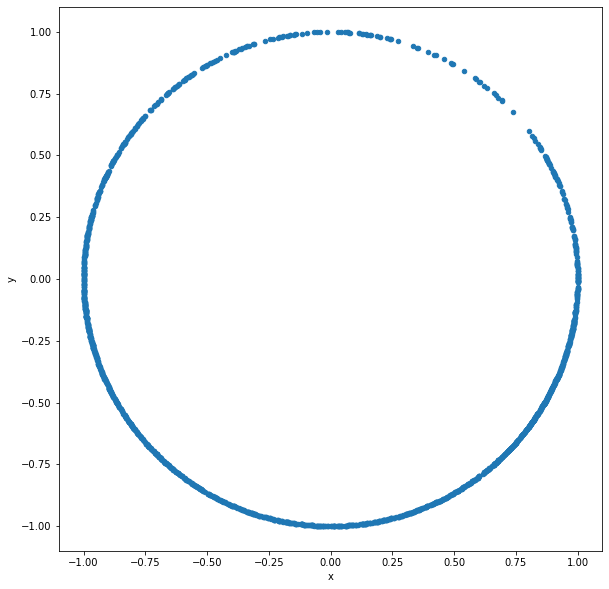

In [9]:
df.sample(2000).plot.scatter('x','y', figsize=(10, 10)).set_aspect('equal');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


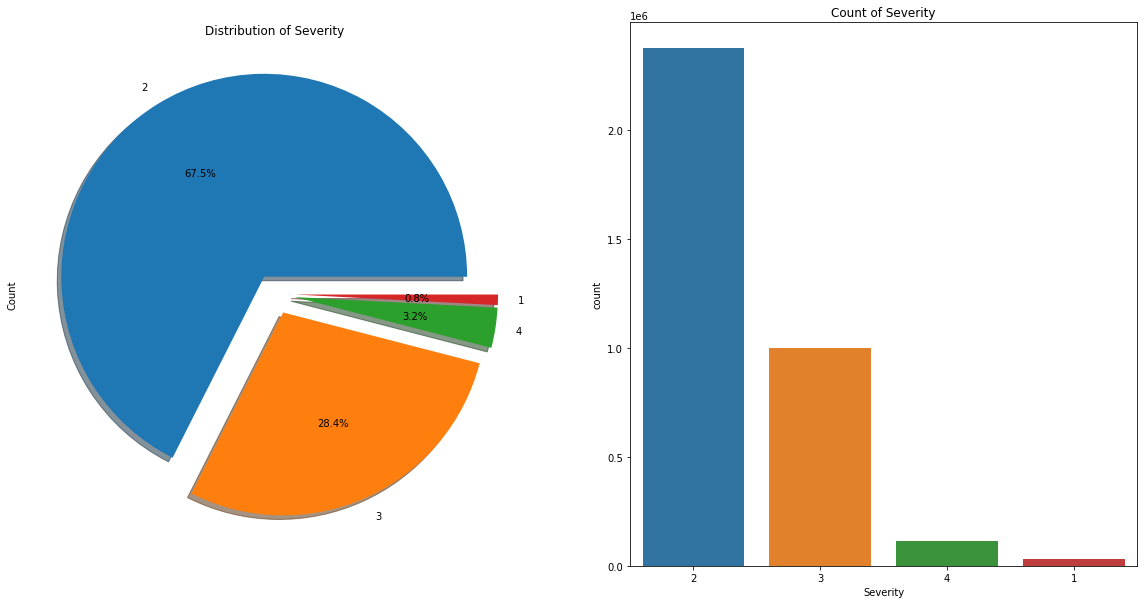

In [10]:
#pie chart and bar graph of label class distribution
f,ax=plt.subplots(1,2,figsize=(20,10))
df['Severity'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distribution of Severity')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=df,ax=ax[1],order=df['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

Proximity to Traffic Object

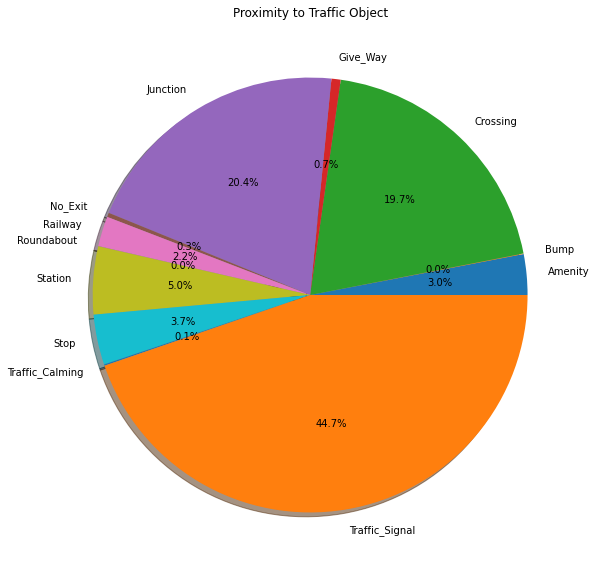

In [11]:
bool_cols = ['Amenity',	'Bump',	'Crossing',	'Give_Way',	'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
booldf = df[bool_cols]
bools = booldf.sum(axis=0)

bools.plot.pie(autopct='%1.1f%%',shadow=True,figsize=(10,10))
plt.ylabel('')
plt.title('Proximity to Traffic Object');

Plot accidents against US map

In [12]:
#separate into different groups based on latitude/longitude and accident severity
lat_1 = df[df.Severity == 1]['Start_Lat'].values
lon_1 = df[df.Severity == 1]['Start_Lng'].values
lat_2 = df[df.Severity == 2]['Start_Lat'].values
lon_2 = df[df.Severity == 2]['Start_Lng'].values
lat_3 = df[df.Severity == 3]['Start_Lat'].values
lon_3 = df[df.Severity == 3]['Start_Lng'].values
lat_4 = df[df.Severity == 4]['Start_Lat'].values
lon_4 = df[df.Severity == 4]['Start_Lng'].values

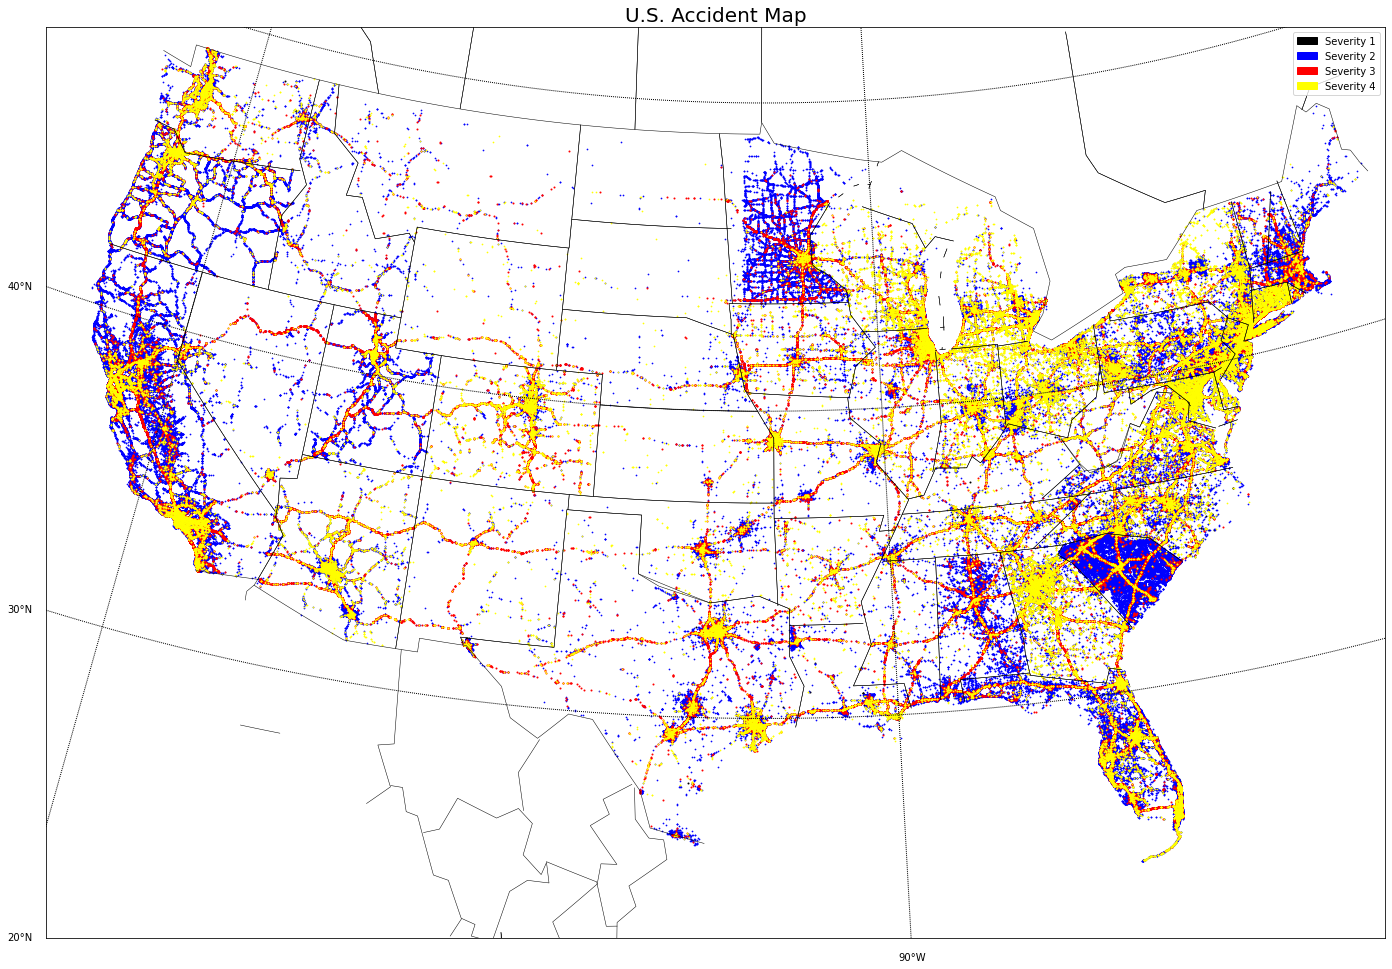

In [13]:
fig, ax = plt.subplots(figsize=(24,18))

# read in data to use for plotted points

# determine range to print based on min, max lat and lon of the data

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawstates()
m.drawcountries()
m.drawparallels(np.arange(-90,90,10),labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])


m.scatter(lon_1,lat_1,latlon=True, s=1, c='black')
m.scatter(lon_2,lat_2,latlon=True, s=.5, c='blue')
m.scatter(lon_3,lat_3,latlon=True, s=1, c='red')
m.scatter(lon_4,lat_4,latlon=True, s=.5, c='yellow')

red = mpatches.Patch(color='red', label='Severity 3')
yel = mpatches.Patch(color='yellow', label='Severity 4')
blu = mpatches.Patch(color='blue', label='Severity 2')
bla = mpatches.Patch(color='black', label='Severity 1')
plt.legend(handles=[bla, blu, red, yel])

plt.title('U.S. Accident Map', fontsize=20)
plt.show()

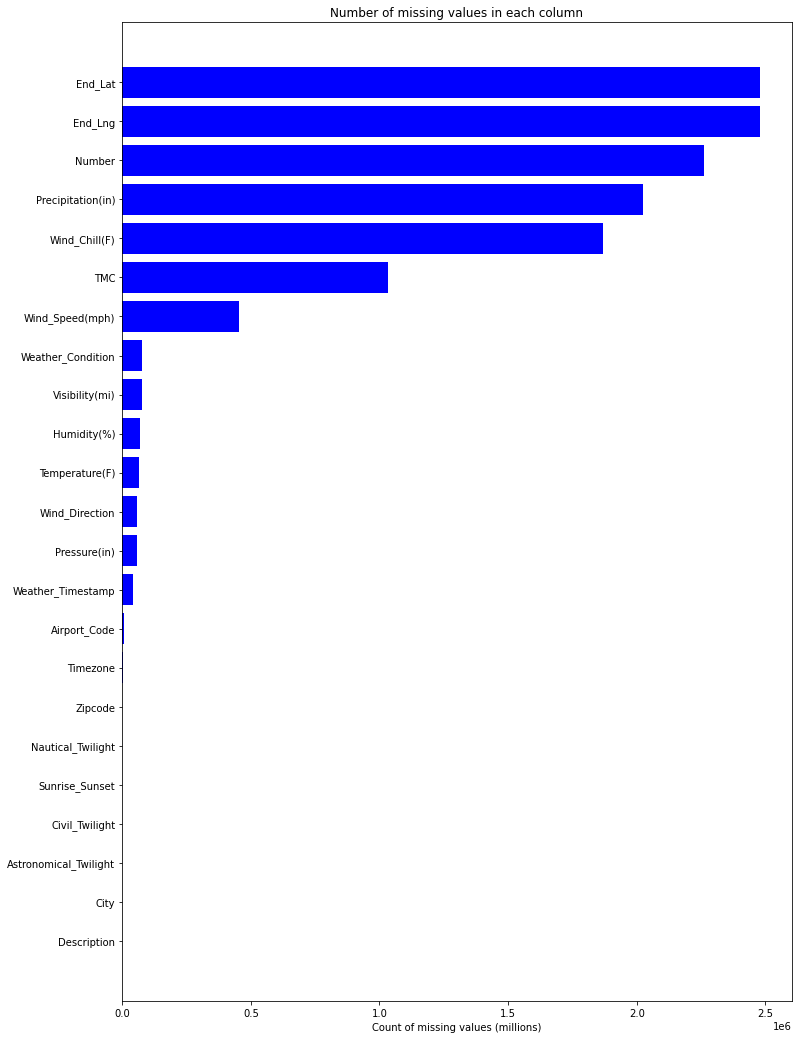

In [14]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (millions)")
ax.set_title("Number of missing values in each column")
plt.show()

get the ratio and the columns with more missing values above 80%

In [15]:
missing = df.isnull().sum(axis=0).reset_index()
missing.columns = ['columns_name','missing_count']
missing['missing_ratio'] = missing['missing_count'] / df.shape[0]
missing.loc[missing['missing_ratio']>0.80]

,columns_name,missing_count,missing_ratio
0,ID,0,0.000000e+00
1,Source,0,0.000000e+00
2,TMC,1034799,2.945110e-01
3,Severity,0,0.000000e+00
4,Start_Time,0,0.000000e+00
5,End_Time,0,0.000000e+00
6,Start_Lat,0,0.000000e+00
7,Start_Lng,0,0.000000e+00
8,End_Lat,2478818,7.054890e-01
9,End_Lng,2478818,7.054890e-01


In [16]:
missin = missing.loc[missing['missing_count']>250000] #vary this value?
removelist = missin['columns_name'].tolist() 

On to trimming the data set

In [30]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','x','y']

In [31]:
df2 = df[feature_lst].copy()

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

In [32]:
x_cols = [col for col in df2.columns if col not in ['Severity'] if df2[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df2[col].values, df2.Severity.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


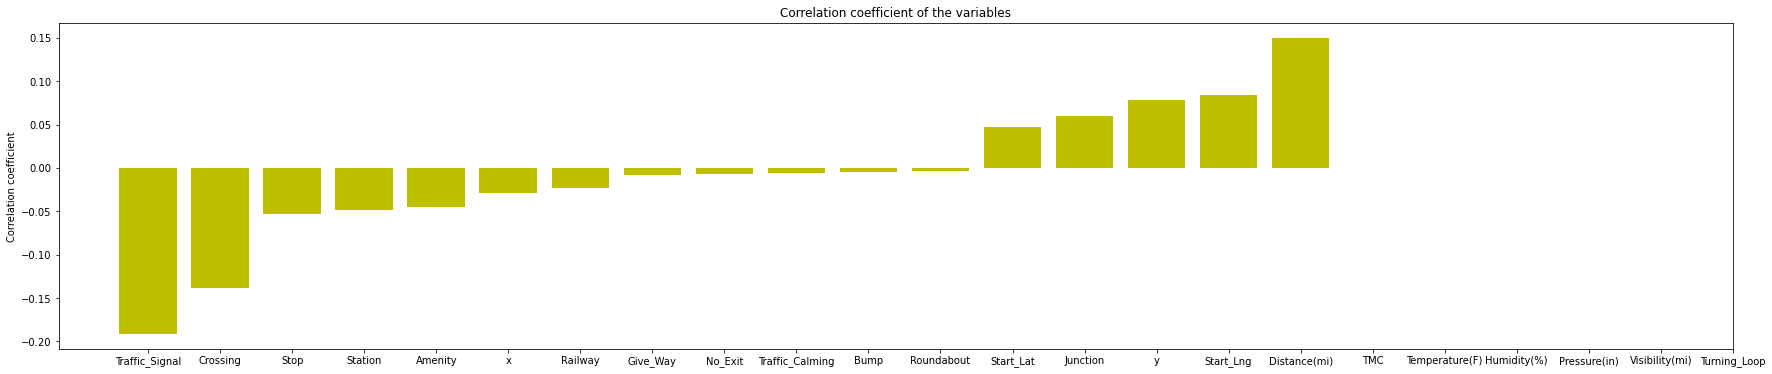

In [33]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(30,6))
rects = ax.bar(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_xticks(ind)
ax.set_xticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_ylabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

The correlation of the target variable with the given set of variables are low overall.

there are some variable with no correlation

In [35]:
zero_corr = ['Turning_Loop','Visibility(mi)','Pressure(in)','Humidity(%)','Temperature(F)','TMC']
for col in zero_corr:
    print(col,len(df2[col].unique()))

Turning_Loop 1
Visibility(mi) 86
Pressure(in) 1023
Humidity(%) 101
Temperature(F) 832
TMC 22


get highly correlated columns

In [36]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.05) | (corr_df['corr_values'] < -0.05)]
corr_df_sel

,col_labels,corr_values
19,Traffic_Signal,-0.191532
10,Crossing,-0.138367
17,Stop,-0.053500
12,Junction,0.060085
22,y,0.078263
1,Start_Lng,0.083707
3,Distance(mi),0.150328


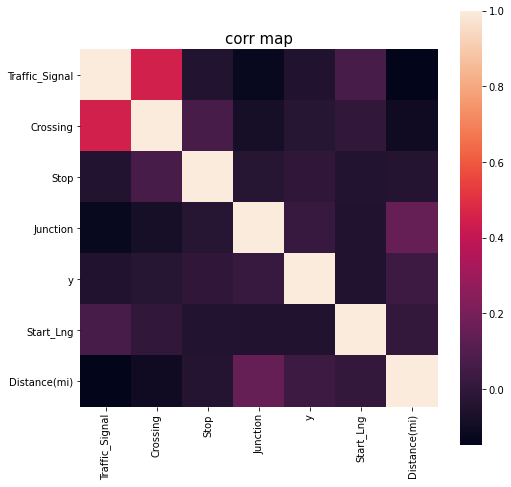

In [38]:
corr_df_ = corr_df_sel.col_labels.tolist()

tdf = df2[corr_df_]

corrmat = tdf.corr(method='spearman')
fig,ax= plt.subplots(figsize=(8,8))

sns.heatmap(corrmat,vmax=1,square = True)
plt.title('corr map',fontsize=15)
plt.show()

lets once check for all the vriables 

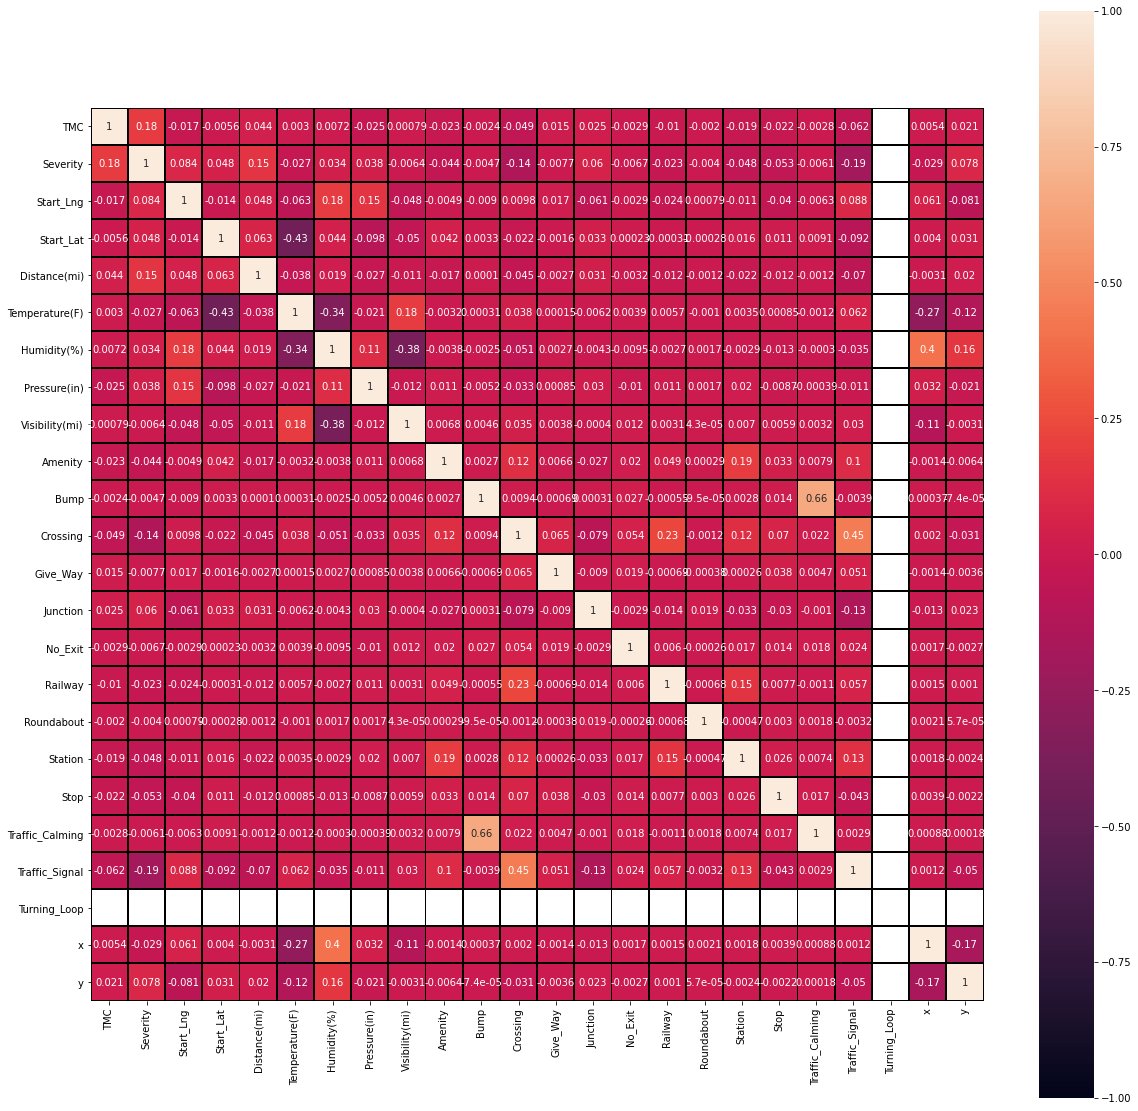

In [39]:
fig=plt.gcf()
fig.set_size_inches(20,20)
fig=sns.heatmap(df2.corr(),annot=True,linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)

In [43]:
#drop rows with nans (we decided that since there was still a huge number of records, it would be a step we would take to reduce the dataset)
df2.dropna(subset=df2.columns[df2.isnull().mean()!=0], how='any', axis=0, inplace=True)
df2.shape

(2408070, 32)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


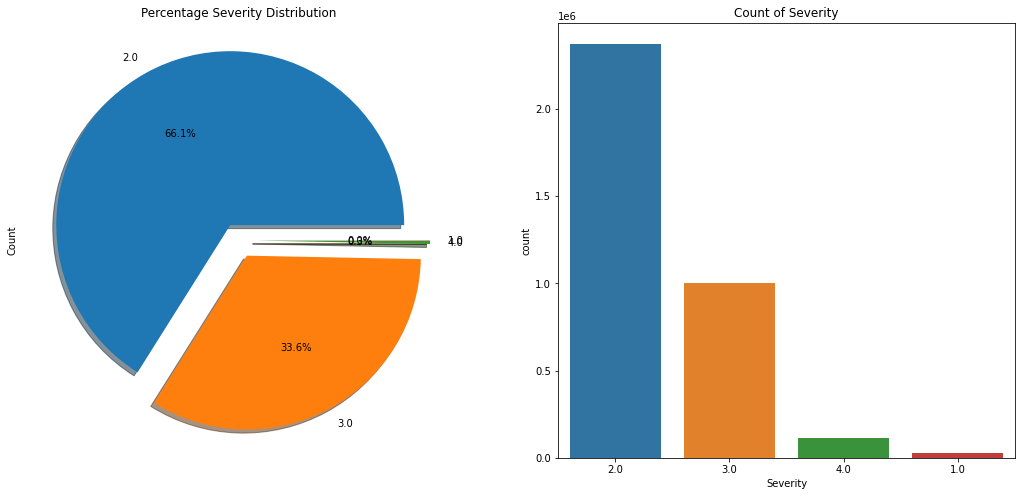

In [44]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df2['Severity'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=df,ax=ax[1],order=df2['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

#distribution of label classes skewed more after drop

In [ ]:
df2 = df2.drop('Turning_Loop', axis=1)
df2

In [46]:
df2['Side'] = pd.Series(np.where(df2.Side.values == 'R', 1, 0),
          df2.index)
df2['Side']

0          1
1          0
2          1
3          1
4          1
          ..
2478813    1
2478814    1
2478815    0
2478816    1
2478817    1
Name: Side, Length: 2408070, dtype: int64

In [48]:
df2['Sunrise_Sunset'] = pd.Series(np.where(df2['Sunrise_Sunset'].values == 'Day', 1, 0),
          df2.index)
df2['Sunrise_Sunset']
df2

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,x,y
0,MapQuest,201.0,3.0,-84.058723,39.865147,0.01,1,Dayton,Montgomery,OH,US/Eastern,36.9,91.0,29.68,10.0,Calm,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.998135,0.061049
1,MapQuest,201.0,2.0,-82.831184,39.928059,0.01,0,Reynoldsburg,Franklin,OH,US/Eastern,37.9,100.0,29.65,10.0,Calm,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.999534,-0.030539
2,MapQuest,201.0,2.0,-84.032608,39.063148,0.01,1,Williamsburg,Clermont,OH,US/Eastern,36.0,100.0,29.67,10.0,SW,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.977231,-0.212178
3,MapQuest,201.0,3.0,-84.205582,39.747753,0.01,1,Dayton,Montgomery,OH,US/Eastern,35.1,96.0,29.64,9.0,SW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.935135,-0.354291
4,MapQuest,201.0,2.0,-84.188354,39.627781,0.01,1,Dayton,Montgomery,OH,US/Eastern,36.0,89.0,29.65,6.0,SW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.908143,-0.418660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,MapQuest,201.0,3.0,-118.623932,34.495808,0.00,1,Castaic,Los Angeles,CA,US/Pacific,100.0,18.0,28.85,10.0,WNW,Fair,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.984041,0.177944
2478814,MapQuest,201.0,3.0,-118.433723,34.031322,0.00,1,Los Angeles,Los Angeles,CA,US/Pacific,77.0,64.0,29.69,10.0,SSW,Clear,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.967046,0.254602
2478815,MapQuest,201.0,3.0,-117.369102,34.106785,0.00,0,Rialto,San Bernardino,CA,US/Pacific,102.2,16.0,29.73,6.0,SSW,Haze,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.969231,0.246153
2478816,MapQuest,201.0,3.0,-118.103981,33.924686,0.00,1,Norwalk,Los Angeles,CA,US/Pacific,88.0,39.0,29.68,10.0,West,Clear,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.889017,0.457874


In [49]:
#convert categories into numbers
df2['Weather_Condition'] = df2['Weather_Condition'].astype('category')
df2['Wind_Direction'] = df2['Wind_Direction'].astype('category')
cat_columns = df2.select_dtypes(['category']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: x.cat.codes)
df2

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,x,y
0,MapQuest,201.0,3.0,-84.058723,39.865147,0.01,1,Dayton,Montgomery,OH,US/Eastern,36.9,91.0,29.68,10.0,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.998135,0.061049
1,MapQuest,201.0,2.0,-82.831184,39.928059,0.01,0,Reynoldsburg,Franklin,OH,US/Eastern,37.9,100.0,29.65,10.0,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.999534,-0.030539
2,MapQuest,201.0,2.0,-84.032608,39.063148,0.01,1,Williamsburg,Clermont,OH,US/Eastern,36.0,100.0,29.67,10.0,16,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.977231,-0.212178
3,MapQuest,201.0,3.0,-84.205582,39.747753,0.01,1,Dayton,Montgomery,OH,US/Eastern,35.1,96.0,29.64,9.0,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.935135,-0.354291
4,MapQuest,201.0,2.0,-84.188354,39.627781,0.01,1,Dayton,Montgomery,OH,US/Eastern,36.0,89.0,29.65,6.0,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.908143,-0.418660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,MapQuest,201.0,3.0,-118.623932,34.495808,0.00,1,Castaic,Los Angeles,CA,US/Pacific,100.0,18.0,28.85,10.0,21,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.984041,0.177944
2478814,MapQuest,201.0,3.0,-118.433723,34.031322,0.00,1,Los Angeles,Los Angeles,CA,US/Pacific,77.0,64.0,29.69,10.0,15,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.967046,0.254602
2478815,MapQuest,201.0,3.0,-117.369102,34.106785,0.00,0,Rialto,San Bernardino,CA,US/Pacific,102.2,16.0,29.73,6.0,15,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.969231,0.246153
2478816,MapQuest,201.0,3.0,-118.103981,33.924686,0.00,1,Norwalk,Los Angeles,CA,US/Pacific,88.0,39.0,29.68,10.0,23,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.889017,0.457874


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408070 entries, 0 to 2478817
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Source             object 
 1   TMC                float64
 2   Severity           float64
 3   Start_Lng          float64
 4   Start_Lat          float64
 5   Distance(mi)       float64
 6   Side               int64  
 7   City               object 
 8   County             object 
 9   State              object 
 10  Timezone           object 
 11  Temperature(F)     float64
 12  Humidity(%)        float64
 13  Pressure(in)       float64
 14  Visibility(mi)     float64
 15  Wind_Direction     int8   
 16  Weather_Condition  int8   
 17  Amenity            float64
 18  Bump               float64
 19  Crossing           float64
 20  Give_Way           float64
 21  Junction           float64
 22  No_Exit            float64
 23  Railway            float64
 24  Roundabout         float64
 25  Station           

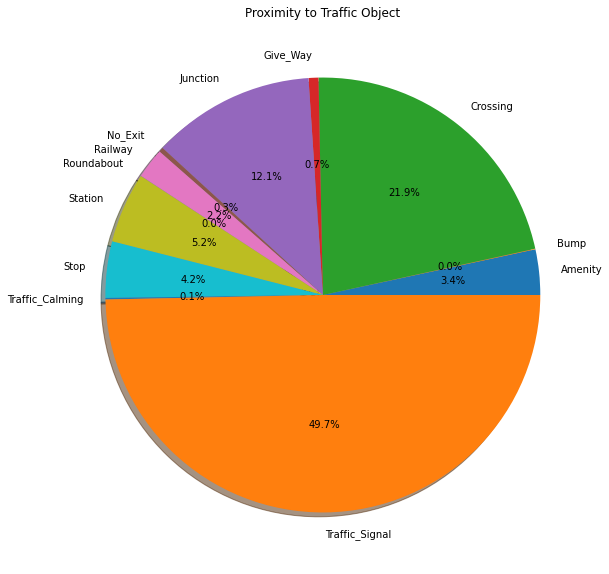

In [50]:
bool_cols = ['Amenity',	'Bump',	'Crossing',	'Give_Way',	'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
booldf = df2[bool_cols]
bools = booldf.sum(axis=0)

bools.plot.pie(autopct='%1.1f%%',shadow=True,figsize=(10,10))
plt.ylabel('')
plt.title('Proximity to Traffic Object');

In [ ]:
df2.to_csv('/content/gdrive/My Drive/CMPE 255 Project/reprocessed.csv', index=False)

Separate Dataset With Normalized Data

In [ ]:
temp = df2[['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(temp)
scaled_data

array([[0.33622449, 0.90909091, 0.89830508, 0.07142857],
       [0.34132653, 1.        , 0.89739709, 0.07142857],
       [0.33163265, 1.        , 0.89800242, 0.07142857],
       ...,
       [0.66938776, 0.15151515, 0.8998184 , 0.04285714],
       [0.59693878, 0.38383838, 0.89830508, 0.07142857],
       [0.60510204, 0.39393939, 0.90133172, 0.07142857]])

In [ ]:
len(scaled_data)

2408070

In [ ]:
temp_df = pd.DataFrame(data=scaled_data, columns=['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)'])

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
0,0.336224,0.909091,0.898305,0.071429
1,0.341327,1.000000,0.897397,0.071429
2,0.331633,1.000000,0.898002,0.071429
3,0.327041,0.959596,0.897094,0.064286
4,0.331633,0.888889,0.897397,0.042857
...,...,...,...,...
2408065,0.658163,0.171717,0.873184,0.071429
2408066,0.540816,0.636364,0.898608,0.071429
2408067,0.669388,0.151515,0.899818,0.042857
2408068,0.596939,0.383838,0.898305,0.071429


In [ ]:
df2 = df2.drop(['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)'], axis=1)
df2

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,State,Timezone,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,x,y
0,MapQuest,201.0,3.0,-84.058723,39.865147,0.01,1,Dayton,Montgomery,OH,US/Eastern,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.998135,0.061049
1,MapQuest,201.0,2.0,-82.831184,39.928059,0.01,0,Reynoldsburg,Franklin,OH,US/Eastern,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.999534,-0.030539
2,MapQuest,201.0,2.0,-84.032608,39.063148,0.01,1,Williamsburg,Clermont,OH,US/Eastern,16,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.977231,-0.212178
3,MapQuest,201.0,3.0,-84.205582,39.747753,0.01,1,Dayton,Montgomery,OH,US/Eastern,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.935135,-0.354291
4,MapQuest,201.0,2.0,-84.188354,39.627781,0.01,1,Dayton,Montgomery,OH,US/Eastern,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.908143,-0.418660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,MapQuest,201.0,3.0,-118.623932,34.495808,0.00,1,Castaic,Los Angeles,CA,US/Pacific,21,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.984041,0.177944
2478814,MapQuest,201.0,3.0,-118.433723,34.031322,0.00,1,Los Angeles,Los Angeles,CA,US/Pacific,15,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.967046,0.254602
2478815,MapQuest,201.0,3.0,-117.369102,34.106785,0.00,0,Rialto,San Bernardino,CA,US/Pacific,15,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.969231,0.246153
2478816,MapQuest,201.0,3.0,-118.103981,33.924686,0.00,1,Norwalk,Los Angeles,CA,US/Pacific,23,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.889017,0.457874


In [ ]:
df2= df2.drop(['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)'], axis=1)

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,State,Timezone,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,x,y
0,MapQuest,201.0,3.0,-84.058723,39.865147,0.01,1,Dayton,Montgomery,OH,US/Eastern,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.998135,0.061049
1,MapQuest,201.0,2.0,-82.831184,39.928059,0.01,0,Reynoldsburg,Franklin,OH,US/Eastern,1,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.999534,-0.030539
2,MapQuest,201.0,2.0,-84.032608,39.063148,0.01,1,Williamsburg,Clermont,OH,US/Eastern,16,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.977231,-0.212178
3,MapQuest,201.0,3.0,-84.205582,39.747753,0.01,1,Dayton,Montgomery,OH,US/Eastern,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.935135,-0.354291
4,MapQuest,201.0,2.0,-84.188354,39.627781,0.01,1,Dayton,Montgomery,OH,US/Eastern,16,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.908143,-0.418660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,MapQuest,201.0,3.0,-118.623932,34.495808,0.00,1,Castaic,Los Angeles,CA,US/Pacific,21,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.984041,0.177944
2478814,MapQuest,201.0,3.0,-118.433723,34.031322,0.00,1,Los Angeles,Los Angeles,CA,US/Pacific,15,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.967046,0.254602
2478815,MapQuest,201.0,3.0,-117.369102,34.106785,0.00,0,Rialto,San Bernardino,CA,US/Pacific,15,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.969231,0.246153
2478816,MapQuest,201.0,3.0,-118.103981,33.924686,0.00,1,Norwalk,Los Angeles,CA,US/Pacific,23,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.889017,0.457874


In [ ]:
df2['Temperature(F)'] = temp_df['Temperature(F)'].iloc[:].values
df2['Humidity(%)'] = temp_df['Humidity(%)'].iloc[:].values
df2['Pressure(in)'] = temp_df['Pressure(in)'].iloc[:].values
df2['Visibility(mi)'] = temp_df['Visibility(mi)'].iloc[:].values

In [ ]:
df2.to_csv('/content/gdrive/My Drive/CMPE 255 Project/normalized_float_values_for_regression_if_needed.csv', index=False)